## Create a Grid of NxN Cells
### N should be an input by user

I'll create a json that will contains the coordinates of each cell(square). Json must contain for each cell the:
* CellId 
* upper side(max latitude)
* bottom side(min latitude)
* right side(max longitude)
* left side(min longitude)

In [1]:
while True:
        try:
            N = int(input('Insert the number of Cells per row/column.'))
            break
        except:
            print("That's not a valid option!")

The history saving thread hit an unexpected error (DatabaseError('database disk image is malformed')).History will not be written to the database.
Insert the number of Cells per row/column.4


In [2]:
# Given the N number of cells we must calculate the length of horizontal/vertical sides of each cell.
num_of_cells = N*N
hor_len = 360/N
ver_len = 180/N
print(hor_len, ver_len, num_of_cells)

90.0 45.0 16


In [3]:
cells=[]
max_ver=90
min_ver=90-ver_len
min_hor=-180-hor_len
max_hor=-180
for c in range(1,num_of_cells+1):
    min_hor+=hor_len
    max_hor+=hor_len
    temp_cell = {"cell":c,
                 "max_lat": max_ver,
                 "min_lat": min_ver,
                 "min_lon": min_hor,
                 "max_lon": max_hor
                }
    cells.append(temp_cell)
    if max_hor==180:
        min_hor= -180-hor_len
        max_hor= -180
        max_ver-=ver_len
        min_ver-=ver_len
    
    

In [4]:
cells

[{'cell': 1,
  'max_lat': 90,
  'min_lat': 45.0,
  'min_lon': -180.0,
  'max_lon': -90.0},
 {'cell': 2, 'max_lat': 90, 'min_lat': 45.0, 'min_lon': -90.0, 'max_lon': 0.0},
 {'cell': 3, 'max_lat': 90, 'min_lat': 45.0, 'min_lon': 0.0, 'max_lon': 90.0},
 {'cell': 4,
  'max_lat': 90,
  'min_lat': 45.0,
  'min_lon': 90.0,
  'max_lon': 180.0},
 {'cell': 5,
  'max_lat': 45.0,
  'min_lat': 0.0,
  'min_lon': -180.0,
  'max_lon': -90.0},
 {'cell': 6,
  'max_lat': 45.0,
  'min_lat': 0.0,
  'min_lon': -90.0,
  'max_lon': 0.0},
 {'cell': 7, 'max_lat': 45.0, 'min_lat': 0.0, 'min_lon': 0.0, 'max_lon': 90.0},
 {'cell': 8,
  'max_lat': 45.0,
  'min_lat': 0.0,
  'min_lon': 90.0,
  'max_lon': 180.0},
 {'cell': 9,
  'max_lat': 0.0,
  'min_lat': -45.0,
  'min_lon': -180.0,
  'max_lon': -90.0},
 {'cell': 10,
  'max_lat': 0.0,
  'min_lat': -45.0,
  'min_lon': -90.0,
  'max_lon': 0.0},
 {'cell': 11,
  'max_lat': 0.0,
  'min_lat': -45.0,
  'min_lon': 0.0,
  'max_lon': 90.0},
 {'cell': 12,
  'max_lat': 0.0,
  'm

In [5]:
from pyspark import SparkConf,SparkContext
from pyspark.streaming import StreamingContext
from pyspark.sql import SQLContext
from pyspark.sql.functions import udf
from pyspark.sql.types import IntegerType
from pyspark.sql.functions import desc
import json

In [6]:
sc = SparkContext()# we initiate the StreamingContext with 10 second batch interval. #next we initiate our sqlcontext
ssc = StreamingContext(sc, 10)
# setting a checkpoint to allow RDD recovery
ssc.checkpoint("checkpoint_TwitterApp")
sqlContext = SQLContext(sc)

In [7]:
# initiate streaming text from a TCP (socket) source:
socket_stream = ssc.socketTextStream("127.0.0.1", 5555)# lines of tweets with socket_stream window of size 60, or 60 #seconds windows of time
# lines = socket_stream.window(60)
# socket_stream.pprint()

In [8]:
def aggregate_cells_count(new_values, total_sum):
    return sum(new_values) + (total_sum or 0)

In [9]:
# # Split each line into words
tweets = socket_stream.map(lambda line: (json.loads(line)['geo']['coordinates'][0],json.loads(line)['geo']['coordinates'][1],json.loads(line)['text'] ))

# Custom Preset 4-Cells Grid
## full = tweets.map(lambda t: (1 if (t[0]>0 and t[1]<0) else (2 if(t[0]>0 and t[1]>0) else (3 if(t[0]<0 and t[1]<0) else 4)), t[0], t[1], t[2]    ))
## num_partitions = tweets.map(lambda t: 1 if (t[0]>0 and t[1]<0) else (2 if(t[0]>0 and t[1]>0) else (3 if(t[0]<0 and t[1]<0) else 4))).map(lambda x: (x,1))


full = tweets.map(lambda t: [(c["cell"], t[0], t[1], t[2]) for c in cells if (t[0]<c["max_lat"] and t[0]>c["min_lat"] and t[1]>c["min_lon"] and t[1]<c["max_lon"] )] ).map(lambda x: x[0])
num_partitions = tweets.map(lambda t: [c["cell"] for c in cells if (t[0]<c["max_lat"] and t[0]>c["min_lat"] and t[1]>c["min_lon"] and t[1]<c["max_lon"] )]).map(lambda x: (x[0],1))



cells_totals = num_partitions.updateStateByKey(aggregate_cells_count)

## Print full object Schema: (cell,latitude,longitude,text)
full.pprint()

## Print the number of objects to cell per batch
#num_partitions.pprint()

## Print the total count of object in each cell
cells_totals.pprint()

In [10]:
from collections import namedtuple

fields = ("cell", "count")
Tweet = namedtuple( 'Tweet', fields )

(cells_totals.map(lambda rec: Tweet( rec[0], rec[1] ) ).foreachRDD(lambda rdd: rdd.toDF().sort( desc("count") ).registerTempTable("tweets_per_cell")) ) 



In [11]:
# start streaming and wait couple of minutes to get enought tweets
ssc.start()


-------------------------------------------
Time: 2020-07-10 17:45:00
-------------------------------------------

-------------------------------------------
Time: 2020-07-10 17:45:00
-------------------------------------------

-------------------------------------------
Time: 2020-07-10 17:45:10
-------------------------------------------
(8, 37.54897926, 126.92306641, 'Autumn design Korean café. @ KREAM https://t.co/a2ULKVcHAA')
(3, 45.41624665, 11.88334465, 'Ci sono ancora pochi posti liberi per la settimana 20-24 luglio…\nContinua la possibilità di iscriversi ai Laborator… https://t.co/6o31UZIQEl')
(3, 51.586623, 3.60822, '🔴 #VROUWENPOLDER #LFL03 🚁 #p2000 \nA1 (DIA) Vroondijk Vrouwenpolder 82954\n https://t.co/5ZW89KNbcz')
(10, -9.88165795, -56.08734542, '📍 CASA A VENDA 📍\n\n👉 Residencial Floresta, um lugar excelente para se morar, onde você encontra uma infraestrutura c… https://t.co/1oEcgG6Jn2')
(11, -10.64185839, 58.54085943, '263939ce16310135200a26bdc9dfd32cf189dea70f752e5537

## Visualize the total count of objects per Cell

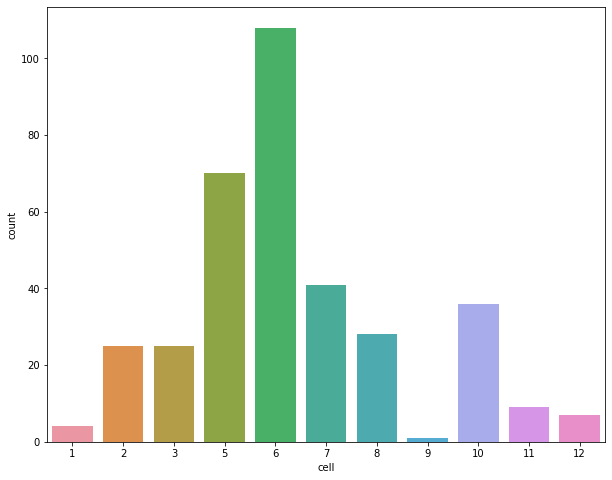

Current Time = 17:47:34
-------------------------------------------
Time: 2020-07-10 17:47:40
-------------------------------------------
(5, 42.0, -91.63, 'At 6:00 AM CDT, 3 NE Cedar Rapids [Linn Co, IA] COCORAHS reports HEAVY RAIN of 1.44 INCH. 24-HR TOTAL. COCORAHS STA… https://t.co/y8Xe6FEa3q')
(2, 53.7972, -0.33208, '"Sugared doughnuts " in #Hull #UnitedKingdom https://t.co/T6I4eC1zdO #foodwaste #free')
(3, 51.0, 10.0, 'THE KING’S ARMY UPDATE:  Farbod finishing up back day with straight arm pull downs. This is a great exercise for bu… https://t.co/iXC7CuXQEk')
(11, -26.1369, 27.8709, 'Just posted a photo @ Roodepoort, Gauteng https://t.co/35dQTjyXnB')
(6, 38.8951, -77.0367, 'There’s no Reason for a Plan B, it’ll just  distract you from A! 1st off Thank you so much to my amazing… https://t.co/YiWiOp0q55')
(7, 41.2360262, 16.5313085, '«Cuando un trato parece demasiado bueno para ser verdad, adivina el resto» en Grotte Di Ripalta - Costa Adriatica B… https://t.co/7QHW6V52mU')
(1, 48.

-------------------------------------------
Time: 2020-07-10 17:48:20
-------------------------------------------
(8, 35)
(12, 12)
(5, 81)
(1, 5)
(9, 1)
(10, 48)
(6, 143)
(2, 31)
(3, 36)
(11, 12)
...

-------------------------------------------
Time: 2020-07-10 17:48:30
-------------------------------------------
(6, 40.568065, -73.877156, 'back at my birthplace!🖤 and s/o sevillastudios for the sick hoodie🦋 @ Rockaway Beach https://t.co/73FjFw87lo')
(6, 38.62700955, -77.25274961, '@doreencougar we go the extra mile to assure the safety of you and your belongings. #wecleanforyourhealth… https://t.co/CVtqJid9eu')
(3, 52.232222, 21.008333, '#RT Lame Crusade - Left and right unites in bashing celebs letter criticising cancel... https://t.co/XBDC6Vl48w')
(7, 44.97618904, 34.09599608, 'Все провожают в аэропорту sip_aero 😊✈️ crimnelichka  #russia #crimea #simferopol #аэропортсимферополь @ Россия, Кры… https://t.co/vhWnMJI8OY')
(5, 29.4241219, -98.4936282, 'Can you recommend anyone for this jo

-------------------------------------------
Time: 2020-07-10 17:49:10
-------------------------------------------
(8, 43)
(12, 15)
(5, 98)
(1, 10)
(9, 1)
(10, 57)
(6, 173)
(2, 35)
(3, 46)
(11, 13)
...

-------------------------------------------
Time: 2020-07-10 17:49:20
-------------------------------------------
(5, 19.36616653, -99.17651411, 'Así quedó el sorteo de la Champions League: Así quedaron los emparejamientos que se disputará entre el 12 y el 23 d… https://t.co/tQJtJfPE2w')
(6, 43.27527778, -4.98527778, '¿Sabéis que si caminas alrededor de los Lagos de Covadonga te acabas encontrando con un bosque que pasaría sin esfu… https://t.co/1K0YezOHDz')
(6, 40.85, -73.8669, 'They don’t build them like  they used too. #drpepperoutdoorstudios @ Bronx, New York https://t.co/cypRXGTGQs')
(6, 25.7751, -80.1936, 'Versace versace!!😈\n•\n•\n•\n📸: @michaeldowns1 @ Miami, Florida https://t.co/LggyxZF30X')
(5, 19.36616653, -99.17651411, 'Spotify, Pinterest y Tinder están fallando en iPhone: Us

-------------------------------------------
Time: 2020-07-10 17:50:00
-------------------------------------------
(8, 48)
(12, 20)
(5, 117)
(1, 12)
(9, 1)
(10, 62)
(6, 210)
(2, 45)
(3, 56)
(11, 14)
...

-------------------------------------------
Time: 2020-07-10 17:50:10
-------------------------------------------
(11, -6.2678857, 14.250621, 'Makanda merdimakanda3@gmail.com à Mbanza Kongo, Zaire, Angola https://t.co/j4hX62pF3z')
(6, 36.78477964, -3.14624342, 'Fondos de almendra amarga, sabores naturales de nuestro Vijiriego blanco.\n#poetaennuevayork #bodegaramblahuarea… https://t.co/6Y1P9yhwbb')
(2, 52.31942827, -1.31889513, 'One of my favourite places to run 🏃🏻\u200d♀️ especially because of the cream tea as my treat 😋 #fivemiler #loverunning @… https://t.co/9XemjI6FBB')
(7, 19.17419, 72.96865, 'The whole series was supposed to mean something else. But after the past events, I was very unsure of even putting… https://t.co/4ERmmgPYxX')
(6, 5.3413, -4.0281, 'Plateforme de mise en relat

-------------------------------------------
Time: 2020-07-10 17:50:50
-------------------------------------------
(8, 56)
(12, 24)
(5, 131)
(1, 15)
(9, 1)
(10, 77)
(6, 247)
(2, 60)
(3, 69)
(11, 21)
...

-------------------------------------------
Time: 2020-07-10 17:51:00
-------------------------------------------
(6, 28.4479, -16.45732, 'Buenas 🤗,acabado el encargo de mi hija, Elfa, óleo en lienzo tela 55x38 cm, mi hija está encantada☺️👍 feliz tarde.… https://t.co/sc8t6EHHqx')
(11, -25.82998923, 28.24388268, '228725: (U/D) Roadworks on R21 Northbound after Ramp to Flying Saucer I/C is now clear. Free flowing traffic.')
(6, 42.4184, -71.1053, 'Mom let me dry off on her @beangoods towel! I must be special 🙂\n\n__________________________________________________… https://t.co/HSvyjVMv2a')
(7, 29.9493, 78.16, 'I AM LUCKY , Explained thoroughly @ Haridwar https://t.co/yMT8gSCgeM')
(10, -4.490472, -38.602466, 'Acabou de publicar uma foto em Em Casa, Ocara, Ceará. https://t.co/CeQXGWD5CT')
(

In [12]:
# import libraries to visualize the results
import time
from IPython import display
import matplotlib.pyplot as plt
import seaborn as sns
import pandas
from datetime import datetime
%matplotlib inline
count = 0
while count < 12:
    time.sleep(11)
    cell_counts = sqlContext.sql( 'Select cell, count from tweets_per_cell' )
    cell_counts_df = cell_counts.toPandas()
    display.clear_output(wait=True)
    plt.figure( figsize = ( 10, 8 ) )
    sns.barplot( x="cell", y="count", data=cell_counts_df)
    plt.show()
    count = count + 1
    now = datetime.now()
    current_time = now.strftime("%H:%M:%S")
    print("Current Time =", current_time)  
    


## Stop Streaming

In [13]:
ssc.stop()
